### Swiftkey Autocomplete
Develop an LSTM neural network to predict next words in the SwiftKey app. 

In [5]:
import pandas as pd
import numpy as np

import nltk
from wordcloud import WordCloud
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [7]:
# Used to continue work after training model (it took
# an hour to train)
from keras.models import load_model
model = load_model('lstm_model.keras')

#### Data Import

In [8]:
filePath = 'data/en_US.twitter.txt'

In [9]:
# Set up NLTK which I'll use to preprocess tweets
# Download the Punkt Sentence Tokenizer
nltk.data.path.append(filePath)
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
# Import as df
data = pd.read_csv(filePath, header = None, sep='\t', names=['text'])

In [11]:
# Preview top and bottom of the df
print(f'File has {round(data.shape[0]/1000000, 2)} million tweets.')
print(data.head())
print(data.tail())

File has 2.34 million tweets.
                                                text
0  How are you? Btw thanks for the RT. You gonna ...
1  When you meet someone special... you'll know. ...
2           they've decided its more fun if I don't.
3  So Tired D; Played Lazer Tag & Ran A LOT D; Ug...
4  Words from a complete stranger! Made my birthd...
                                                      text
2342728  what's good. I see the success you got poppin ...
2342729  RT : Consumers are visual. They want data at t...
2342730                                          u welcome
2342731                                It is #RHONJ time!!
2342732  The key to keeping your woman happy= attention...


In [12]:
# Work with first 5k tweets, otherwise my computer runs out of memory
data = data[:5000]

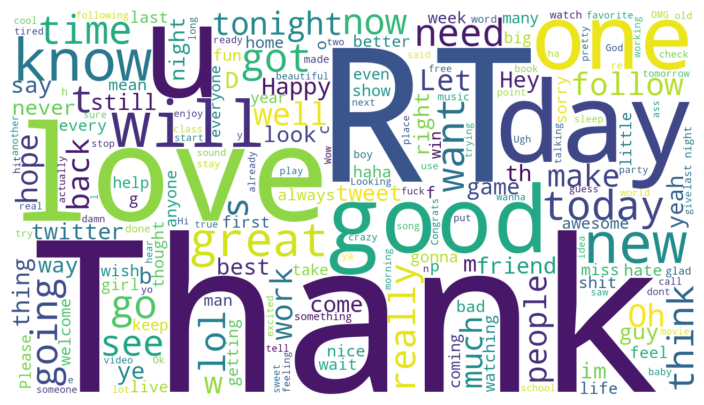

In [13]:
# Take a look at a word cloud (word frequency) of first 100k tweets
# Inspiring to see "Thank" and "Love" are well represented!
wordcloud = WordCloud(width=1280, height=720, background_color='white').generate(data.text.to_string())

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Data Preprocessing

In [14]:
# Work with the pd Series
tweets = data.text

In [15]:
# Trim whitespaces
tweets = tweets.apply(str.strip)

In [16]:
# Lowercase all words
tweets = tweets.apply(str.lower)

In [17]:
# Remove invalid characters, symbols, non-english letters
def remove_non_alphanumeric(text):
  # Replace non-alphanumeric with nothing
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  # Replace extra spaces with 1 space
  text = re.sub(' +', ' ', text)
  return text

tweets = tweets.apply(remove_non_alphanumeric)

In [18]:
# Tokenize (part of keras.preprocessing.text)
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tweets)

In [19]:
print(f'{len(tokenizer.word_index) + 1} unique words across all {tweets.shape[0]} tweets.')

10442 unique words across all 5000 tweets.


In [20]:
# The fitting process assigns integers to unique words, and
# texts_to_sequences converts tweets into arrays of the assigned ints
print(tweets[0])
tokenizer.texts_to_sequences([tweets[0]])[0]

how are you btw thanks for the rt you gonna be in dc anytime soon love to see you been way way too long


[53,
 22,
 6,
 818,
 46,
 8,
 2,
 48,
 6,
 167,
 16,
 10,
 819,
 636,
 186,
 37,
 3,
 72,
 6,
 103,
 115,
 115,
 89,
 196]

In [21]:
sequences = []

for tweet in tweets:
  sequence = tokenizer.texts_to_sequences([tweet])[0]
  for i in range(1, len(sequence)):
    # For each sequence generated from tweets, append
    # to the full sequence. First add the first int, then the
    # first two, then the first three, etc
    n_gram_sequence = sequence[:i+1]
    sequences.append(n_gram_sequence)

In [22]:
print(f"{round(len(sequences)/1000000, 1)} million total sequences processed.")

0.1 million total sequences processed.


In [23]:
# Pad all sequences to the length of the max width sequence
maxLength = max([len(x) for x in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=maxLength, padding='pre'))

print(f"Max length is {maxLength}.")

Max length is 193.


### Build Model

In [ ]:
# Due to heavy computational cost of training, I am not attempting hyperparameter tuning with gridsearch.

In [24]:
# Prepare features and labels
totalWords = len(tokenizer.word_index) + 1
X, labels = sequences[:, :-1], sequences[:, -1]
y = tf.keras.utils.to_categorical(labels, num_classes = totalWords)

In [25]:
model = Sequential()
# Embedding layer turns non-negative integers into dense vectors of fixed size (here 100)
model.add(Embedding(totalWords, 100, input_length=maxLength-1))
# Bidirectional is a wrapper for RNNs (including LSTM). LSTM(units) = 150, dimensionality of the output space
model.add(Bidirectional(LSTM(100)))
# Forward layer using softmax activation (for multiclass classification)
model.add(Dense(totalWords, activation='softmax'))
# An optimizer that uses stochastic gradient descent
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(X, y, epochs=20, verbose=1)

c:\Users\ryans\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 420s 230ms/step - accuracy: 0.0453 - loss: 7.4030
Epoch 2/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 412s 227ms/step - accuracy: 0.0899 - loss: 6.3888
Epoch 3/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 420s 232ms/step - accuracy: 0.1117 - loss: 5.5649
Epoch 4/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 426s 235ms/step - accuracy: 0.1594 - loss: 4.7315
Epoch 5/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 424s 234ms/step - accuracy: 0.2065 - loss: 4.1711
Epoch 6/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 433s 239ms/step - accuracy: 0.2486 - loss: 3.7599
Epoch 7/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 426s 235ms/step - accuracy: 0.2736 - loss: 3.5327
Epoch 8/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 432s 239ms/step - accuracy: 0.2982 - loss: 3.3578
Epoch 9/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 427s 236ms/step - accuracy: 0.3039 - loss: 3.2921
Epoch 10/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 432s 239ms/step - accuracy: 0.3268 - loss: 3.1292
Epoch 11/20
1810/1810 ━━━━━━━━━━━━━━━━━━━━ 433s 239ms/step - accuracy: 0.3070 -

In [ ]:
# Here is where we could build a dictionary of hyperparameter values for Embedding, LSTM, Dense, and Adam for gridsearching. Since this training this model once takes over 2 hours, I will not attempt it.

In [60]:
model.save('lstm_model.keras')

In [3]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 192, 100)       │     1,044,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 300)            │       301,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10442)          │     3,143,042 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,465,328 (51.37 MB)

 Trainable params: 4,488,442 (17.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,976,886 (34.24 MB)

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

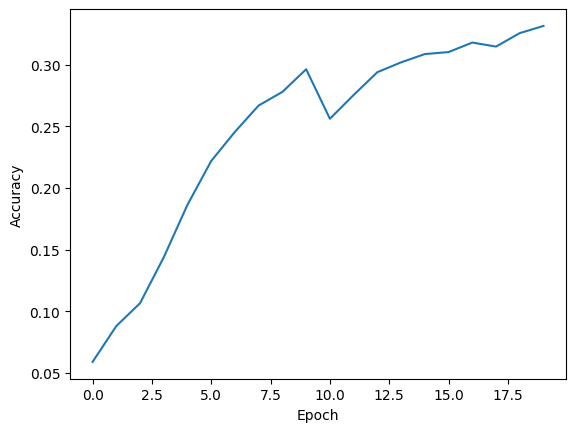

In [31]:
# Accuracy improves quickly until the 9th epoch, then only minor improvements
# byond that.
sns.lineplot(history.history['accuracy']).set(xlabel='Epoch', ylabel='Accuracy')

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Categorical Cross Entropy (Loss)')]

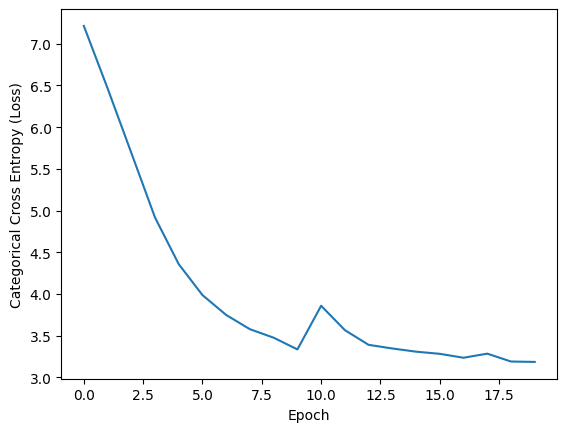

In [30]:
# Similar trend with loss, big improvements in the first 9 epochs, but only
# incremental improvement beyond that.
sns.lineplot(history.history['loss']).set(xlabel='Epoch', ylabel='Categorical Cross Entropy (Loss)')

### Making Predictions

In [37]:
# Predict the next 2 words starting with a seed
seed = 'Winner'

for _ in range(2):
  # Tokenize into integers and pad
  tokens = tokenizer.texts_to_sequences([seed])[0]
  tokens = pad_sequences([tokens], maxlen=maxLength, padding='pre')
  predicted = model.predict(tokens)
  predicted = np.argmax(predicted)
  output = ''
  for word, idx in tokenizer.word_index.items():
    if idx == predicted:
      output = word
      break
  seed += " " + output

print(seed)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Winner will backup
